# A demo of using the Wide_Deep in ContextualBandit algorithm

### Summary of the progress:
- Randomly choose 100000 data points from the data snippet. 
- Construct the contexts and the reward vectors.
- Creat a wide and deep neuron netwrok using Wide_Deep Class
- Run the ContextualBandit with the wide-and-deep model. For every 1000 contexts seen, the following steps are done:
    1. Run the algorithm(in this example it is LinUCB), store the 1000 seen rewards together with their contexts.
    2. Then train the wide and deep model on these 1000 data points for 10 epoches.
    3. Then update the algorithm's parameters (For LinUCB, they are A matrix and B vector) according to all the historical data points in order to keep the algorithm's knowledge by far.
    4. Output the time spent on this 1000 data points. 

- finally plot the cumulative rewards, and print the accuracy.

In [2]:
from Wide_and_Deep_model import Wide_Deep
from Contextual_bandits import ContextualBandit
from algorithms import LinUCB

In [3]:
import pandas as pd
import numpy as np
file_path = "/content/drive/MyDrive/Fellowship.AI/P1_bandit/data_snippet.csv"
df = pd.read_csv(file_path)
df.head()

,riid,opened,rev_3dv2,unsub,campaign_type,retention_score,recency_score,frequency_score
0,242697842,1,75.00,0,Dedicated,14.000000,1.637422,31
1,275469002,1,75.00,0,Dedicated,2.800000,0.000000,0
2,4319542,1,19.98,0,Dedicated,1.000000,0.084239,4
3,166170102,1,19.98,0,Dedicated,0.756757,0.010870,1
4,6998482,1,150.00,0,Dedicated,28.000000,1.845885,18


In [4]:
len(df)

6240490

In [5]:
num_data = 10000
indices = np.random.choice(len(df),size=num_data)
df_subset = df.iloc[indices]

In [6]:
vocab = {riid:i for i, riid in enumerate(df_subset.riid.unique())}

In [7]:
len(vocab)

9842

In [8]:
user_ids = df_subset.riid.apply(lambda x:vocab[x])
c_t = pd.get_dummies(df_subset.campaign_type)

In [9]:
datasource = pd.DataFrame()
datasource['user_ids'] = user_ids

In [10]:
datasource = pd.concat((datasource, c_t),axis=1)

In [11]:
datasource[["retention_score",	"recency_score",	"frequency_score"]] = df_subset[["retention_score",	"recency_score",	"frequency_score"]]

In [12]:
datasource

,user_ids,Brand,Collection,Core,Dedicated,Innovation Spotlight,New Arrivals,Other,Product Spotlight,Replen,Tops,Trend,retention_score,recency_score,frequency_score
2034712,0,0,0,0,0,0,1,0,0,0,0,0,28.000000,4.258540,61
2709653,1,1,0,0,0,0,0,0,0,0,0,0,28.000000,3.684200,74
1159129,2,0,0,0,0,1,0,0,0,0,0,0,1.000000,0.084239,4
4582279,3,0,0,0,1,0,0,0,0,0,0,0,2.333333,0.202446,13
2873522,4,0,0,0,0,0,1,0,0,0,0,0,28.000000,4.194099,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086996,9837,0,0,0,0,0,0,0,0,0,0,1,9.333333,0.582298,5
1570064,9838,0,0,0,0,1,0,0,0,0,0,0,14.000000,1.071234,34
1831478,9839,0,0,0,0,0,0,0,0,0,0,1,1.272727,0.052989,3
4035406,9840,0,0,0,0,0,0,0,1,0,0,0,9.333333,0.331716,9


In [13]:
rewardsource = pd.DataFrame()
rewardsource["reward_send"] = df_subset.opened * 1.2 - 0.2 + (df_subset.rev_3dv2 > 0) + df_subset.rev_3dv2/75.0 - 5.0*df_subset.unsub
rewardsource["reward_not_send"] = -rewardsource["reward_send"]

In [14]:
rewardsource

,reward_send,reward_not_send
2034712,1.0,-1.0
2709653,1.0,-1.0
1159129,1.0,-1.0
4582279,-0.2,0.2
2873522,1.0,-1.0
...,...,...
1086996,1.0,-1.0
1570064,1.0,-1.0
1831478,1.0,-1.0
4035406,-0.2,0.2


In [15]:
opt_a = (rewardsource['reward_send'] < 0).astype(int)

In [16]:
opt_a

2034712    0
2709653    0
1159129    0
4582279    1
2873522    0
          ..
1086996    0
1570064    0
1831478    0
4035406    1
2634900    0
Name: reward_send, Length: 10000, dtype: int64

In [24]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import time

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("training on device: ", device)

training on device:  cuda:0


In [25]:
# model Hyper parameters
wide_dim = 1
deep_dim = 14
action_dim = 2
embeddings={'wide':[['user_id', len(vocab), 64]]}

model = Wide_Deep(wide_dim, deep_dim, action_dim, embeddings=embeddings, deep_neurons=[128, 64]).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.MSELoss()
algorithm = LinUCB(model.z_dim, model.action_dim, delta=0.05)
CB = ContextualBandit(device, model, optimizer, loss_func, algorithm)

# training Hyper parameters
train_batch_size = 64
num_epoch = 10
train_every = 1000

# inputs
contexts = datasource.values
reward_vectors = rewardsource.values
opt_actions = opt_a.values

#start runing the algorithm
train_start_index = 0
start_time = time.time()
pred_actions = []
s_time = start_time
for t in range(num_data):
    context_source = np.array([contexts[t] for i in range(model.action_dim)])
    reward_source = reward_vectors[t]
    pred_a = CB.run(context_source, reward_source)
    pred_actions.append(pred_a)
    if (t+1) % train_every == 0:
        CB.train(start_index=train_start_index, batch_size=train_batch_size, num_epoch=num_epoch)
        train_start_index = t + 1
        print("number of data seen: {:>6} \t time used for previous {} data: {:.3f} sec".format(t+1, train_every, (time.time() - s_time)))
        s_time = time.time()
end_time = time.time()
total_time = end_time - start_time
print("Total time used: {} hrs {} min {} sec".format(int(total_time//3600), int((total_time%3600)//60), total_time%60))

cum_rewards_pred_action = []
cum_rewards_opt_action = []
p_i = 0
o_i = 0
for i in range(num_data):
    p_i += reward_vectors[i][pred_actions[i]]
    o_i += reward_vectors[i][opt_actions[i]]
    cum_rewards_pred_action.append(p_i)
    cum_rewards_opt_action.append(o_i)

This is a wide and deep model.
number of data seen:   1000 	 time used for previous 1000 data: 4.679 sec
number of data seen:   2000 	 time used for previous 1000 data: 5.245 sec
number of data seen:   3000 	 time used for previous 1000 data: 6.051 sec
number of data seen:   4000 	 time used for previous 1000 data: 6.860 sec
number of data seen:   5000 	 time used for previous 1000 data: 7.590 sec
number of data seen:   6000 	 time used for previous 1000 data: 8.266 sec
number of data seen:   7000 	 time used for previous 1000 data: 9.185 sec
number of data seen:   8000 	 time used for previous 1000 data: 9.799 sec
number of data seen:   9000 	 time used for previous 1000 data: 10.730 sec
number of data seen:  10000 	 time used for previous 1000 data: 11.378 sec
Total time used: 0 hrs 1 min 19.785202503204346 sec


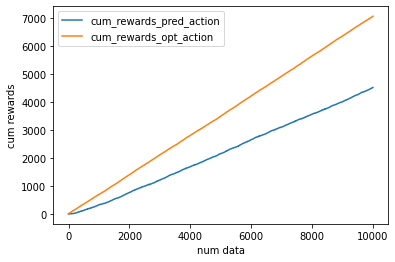

In [26]:
import matplotlib.pyplot as plt
plt.plot(cum_rewards_pred_action, label = 'cum_rewards_pred_action')
plt.plot(cum_rewards_opt_action, label = 'cum_rewards_opt_action')
plt.legend()
plt.xlabel('num data')
_ = plt.ylabel('cum rewards')

In [27]:
np.sum(pred_actions == opt_actions)/num_data

0.7003